# Functions

## Import Functions 

In [1]:
# Use to embed images in Jupyter Notebook
from IPython.display import Image

# Importing necesary modules
import sys
import os
import glob 
from os import listdir
from os import path

# Working with arrays 
import numpy as np

# Working with fits files and WCS objects 
import astropy.units as u
from astropy.time import Time 

# plotting and drawing modules 
from matplotlib import pyplot as plt
import matplotlib as mpl

#additional libraries needed for AFINO
import scipy.optimize as opt 
import scipy.signal as sig

# import reader for IDL files 
from scipy.io import readsav as idlsave

# import stats library 
import scipy.stats as stats 

## Defined Functions

In [2]:
# Define Reconnection Flux Rate  
def recrate(flx,h):
    '''Compute the difference formula for f'(a) with step size h.

    Parameters
    ----------
    flx : array containing reconection flux 
    h: contant cadance beyween observations 
    Returns
    -------
    recrate: reconection flux(a+h) - reconection flux(a-h))/2h
        [negative reconnection rate, positive reconnection rate] 
    '''    
    
    recrate    = np.zeros((2,len(flx[1,:])))
    
    nflux = flx[0] 
    pflux = flx[2]
    recrate[0] = np.gradient(nflux,h,edge_order =2)
    recrate[1] = np.gradient(pflux,h,edge_order =2)
    
    return recrate

In [3]:
# Check if .sav file exists 
def check(filename,bstr,wvstr):
    '''
    Written by Marcel 
    Oct. 21, 2020
    
    inputs: 
            filename -- name of the reconnection flux idl save file
            bstr     -- 
                        BLOS - normal component taken as the line of sight
                        BRAD - normal component taken as the radial magnatic field (B_r)
            wvstr    -- 
    output: 
            savname  -- full filename with extension of the reconnection flux
    '''
    for i in range(len(bstr)): 
        if path.exists(filename+bstr[i]+wvstr+".sav" ) == True:
            return  filename+bstr[i]+wvstr+".sav"
        else: 
            print('File not found! This file does not exist.')

In [4]:
def extract_ribbon_vars(idlstrct):
    '''
    Written by Marcel
    Oct. 5, 2020
    Inputs  --
    Outputs --  OPTIONAL (*) 
                *dosday --?
                flx6 -- magnetic reconnection flux for pixel area with I >= median(I)*6
                flx8 -- magnetic reconnection flux for pixel area with I >= median(I)*8
                flx10 -- magnetic reconnection flux for pixel area with I >= median(I)*10
                * area6 --?
                * area8 --? 
                * area10 --?
                * ar_area --? 
                * mflx --?
                tim -- UTC time from HMI 
                * cut --? 
                * sathr --? 
                * str_brad --? 
                * tim_maxnegrecrate --?    
                * tim_maxposrecrate --?       
                * maxnegrecrate --?        
                * maxposrecrate --?         
                n_o_satpix -- number of saturated points for a given AIA image          
                * bcenx6 --?               
                * bceny6 --?             
                * bcenx8 --?            
                * bceny8 --?            
                * bcenx10 --?             
                * bceny10 --?            
                * dst6 --?                
                * dst8 --?               
                * dst10 --?               

                
    
    Extract all the idl variables 
    '''
    
    flx6                = idlstrct.flx6 
    flx8                = idlstrct.flx8
    flx10               = idlstrct.flx10 
    tim                 = list(idlstrct.tim) #object arrays are not suported by python  
    n_o_satpix          = idlstrct.n_o_satpix
    # These have been commented out because they are not used in the qpp analysis 
    #dosday              = idlstrct.dosday
    area6               = idlstrct.area6 
    area8               = idlstrct.area8 
    area10              = idlstrct.area10 
    ar_area             = idlstrct.ar_area  
    #mflx                = idlstrct.mflx
    #cut                 = idlstrct.cut
    #satthr              = idlstrct.satthr
    #dflxdt              = idlstrct.dflxdt
    #str_brad            = idlstrct.str_brad

    #tim_maxnegrecrate   = idlstrct.tim_maxnegrecrate 
    #tim_maxposrecrate   = idlstrct.tim_maxposrecrate   
    #maxnegrecrate       = idlstrct.maxnegrecrate
    #maxposrecrate       = idlstrct.maxposrecrate 
    #bcenx6              = idlstrct.bcenx6
    #bceny6              = idlstrct.bceny6
    #bcenx8              = idlstrct.bcenx8
    #bceny8              = idlstrct.bceny8
    #bcenx10             = idlstrct.bcenx10
    #bceny10             = idlstrct.bceny10
    #dst6                = idlstrct.dst6
    #dst8                = idlstrct.dst8
    #dst10               = idlstrct.dst10
    
#    return dosday,flx8,flx6,flx10,area6,area8,area10,ar_area,mflx,tim,cut,satthr,dflxdt,str_brad,tim_maxnegrecrate,tim_maxposrecrate,maxnegrecrate,maxposrecrate,n_o_satpix,bcenx6,bceny6,bcenx8,bceny8,bcenx10,bceny10,dst6,dst8,dst10 
#    return dosday,flx8,flx6,flx10,area6,area8,area10,ar_area,mflx,tim,cut,satthr,str_brad,tim_maxnegrecrate,tim_maxposrecrate,maxnegrecrate,maxposrecrate,n_o_satpix,bcenx6,bceny6,bcenx8,bceny8,bcenx10,bceny10,dst6,dst8,dst10 
    return flx6,flx8,flx10,tim,n_o_satpix,area6,area8,area10,ar_area

In [5]:
def utc2jd(tim): 
    '''
    Written by Marcel 
    Oct. 2020
    
    Imput -- 
                tim -- UTC time from IDL sav file
    Output -- 
                jdt -- Julian days converted from UTC time  
                jst -- Julian days converted into seconds 
                js  -- Seconds from the start of the start date in Julian days
                to  -- Time Object dates in UTC-ISOT format
    '''
    jdt = list(np.zeros(len(tim)))
    jst = list(np.zeros(len(tim)))
    js  = list(np.zeros(len(tim)))
    sts = list(np.zeros(len(tim)))

    for i in range(len(tim)): 
        utcstr = str(tim[i])
        utcstr = utcstr.replace('b',"")
        utcstr = utcstr.replace("'",'') 
        sts[i] = utcstr # array of fotmatted dates which can be read by Astropy 
        jdt[i] = Time(utcstr,format='isot')
        jdt[i] = jdt[i].jd
        jst[i] = jdt[i] * 24 * 3600
        js[i]  = jst[i] - jst[0]
    jdt = np.array(jdt)
    jst = np.array(jst)
    js  = np.array(js)
    to  = Time(sts,scale='utc',format='isot') 
    return jdt,jst,js,to

In [6]:
def extract_RDB(flare_data):
    #extract all variables from RibbonDB IDL savefiles 
    rdbflx6,rdbflx8,rdbflx10,tim,n_o_satpix,area6,area8,area10,ar_area = extract_ribbon_vars(flare_data)
    rdbflx = (rdbflx6+rdbflx10)/2 # reconnection flux in Maxwells
   
    #changes from utc to julian calander (in seconds; see ribbon_functions.py)
    _,_,rdbt,rdbtt = utc2jd(tim)
    
    # Evaluate the reconnection rate
    #   negative recflux = rflx[0,:]    
    #   positive recflux = rflx[1,:]
    rdbrflx  = recrate(rdbflx,rdbt[1]-rdbt[0]) # reconnection rate 
                                               # in units of Maxwells per second
    
    #conversion of time to minutes
    rdbt = rdbt/60
       
    return rdbflx,rdbrflx,rdbt,rdbtt,area8,n_o_satpix,ar_area

# Selecting Data

## Define the Data Name

In [7]:
extrdbname = '20140910_1721_12158_X1.6'

## Define the Directories

In [8]:
# Final plot path 
outdir = '/Users/maco7096/WORKING/KAZACHENKO/VERONICA/FirstJob/QPPS_Kaz_Ver/MEDIA_OUT/'

In [9]:
# Define directories with data
datdir = '/Users/maco7096/WORKING/KAZACHENKO/VERONICA/FirstJob/QPPS_Kaz_Ver/DATA/'            #main data directory
rdbdir = datdir + ''   #directory with RDB sav files

# Retriving Data

## Get the RDB file name

In [10]:
# Set filename string components
sathr    = [5000.000,4500.000]
bstr     = ['{:.2f}'.format(sathr[0]) + r"_brad",'{:.2f}'.format(sathr[1]) + r"_brad"]
wvstr    = r""

In [11]:
# Automates the selection of variable bstr for each filename 
flarename   = check(rdbdir + "recfile"+extrdbname+r"_cut08_sat",bstr,wvstr) 
flare_data  = idlsave(flarename,verbose=0)

# Extract Data

In [12]:
rdbflx,rdbrflx,rdbt,rdbtt,area8,n_o_satpix,ar_area = extract_RDB(flare_data)

# This Notebook
- Up to this point the notebook has the same information as the original notebook. 
- In this notebook we will focus only on the reconnection rate `rdbrflx` and time `rdbt` variables. 
- The notebook will show you how to use the [scipy.signal.find_peacks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks) function to characterize the reconnection rate burst period. 

## Define the positive and negative reconnection rates

In [18]:
nrecrate = rdbrflx[0]
precrate = rdbrflx[1]

## Evaluate the peaks

In [31]:
# remember that the find_peaks function gives you the indices at which the peaks are found
positive_peaks = sig.find_peaks(precrate)
negative_peaks = sig.find_peaks(np.abs(nrecrate))

## Evaluate the values of the reconnection rates peaks

In [ ]:
# you can use these indeces to get the reconnection rate peaks
peaks_prate = precrate[positive_peaks[0]]
peaks_nrate = nrecrate[negative_peaks[0]]

## Evaluate the times at which the reconnection rate peaks happen

In [ ]:
# you can use these indeces to get the time of the reconnection rate peaks
peaks_ptime = rdbt[positive_peaks[0]]
peaks_ntime = rdbt[negative_peaks[0]]

## Plot the reconnection rates and their peaks

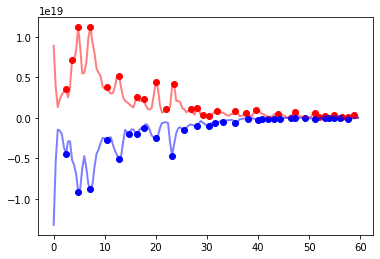

In [32]:
plt.plot(rdbt,precrate,color = 'r', alpha = 0.5, linewidth = 2,zorder = 2)
plt.plot(peaks_ptim,peaks_rate, 'ro',zorder = 1)

plt.plot(rdbt,nrecrate,color = 'b', alpha = 0.5, linewidth = 2,zorder = 2)
plt.plot(peaks_ntime,peaks_nrate, 'bo',zorder = 1)

## Evaluate the oscillation period based on the difference in peak time

The oscillation period is approximated here as the time between peaks and is calculates as $\tau_{osc.}(k) = t_{peak}(k) - t_{peak}(k-1)$, where $k$ are the indices for each of the peak identified with `find_peaks` 

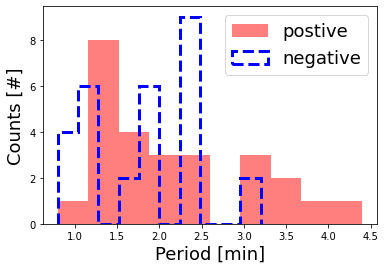

In [48]:
# this is the oscillation period: 
# positive -- peaks_ptime[1:-1] - peaks_ptime[0:-2] 
# negative -- peaks_ntime[1:-1] - peaks_ntime[0:-2]
plt.hist(peaks_ptime[1:-1] - peaks_ptime[0:-2],color = 'red',histtype = 'stepfilled',linewidth = 3,alpha = 0.5, label = 'postive')
plt.hist(peaks_ntime[1:-1] - peaks_ntime[0:-2],color = 'blue',histtype = 'step',linewidth = 3, linestyle = 'dashed',label = 'negative')
plt.ylabel('Counts [#]',fontsize = 18)
plt.xlabel('Period [min]',fontsize = 18)
plt.legend(fontsize = 18)

This histogram shows that the periods found with `find_peaks` have complicated distributions. Therefore we can use different statistics to quantify a global period for each of the signals: 

### Using the `mean` as a global statistic

In [50]:
print(f'The period of the positive reconnection rate is {np.mean(peaks_ptime[1:-1] - peaks_ptime[0:-2])} minutes')
print(f'The period of the negative reconnection rate is {np.mean(peaks_ntime[1:-1] - peaks_ntime[0:-2])} minutes')

The period of the positive reconnection rate is 2.123076923076923 minutes
The period of the negative reconnection rate is 1.8482815797301546 minutes


### Using the `mode` as a global statistic
- Here we will use the `scipy.statistics` module
> -  binning might improve these results but as a rough approximation

In [55]:
print(f'The period of the positive reconnection rate is {stats.mode(peaks_ptime[1:-1] - peaks_ptime[0:-2])[0][0]} minutes')
print(f'The period of the negative reconnection rate is {stats.mode(peaks_ntime[1:-1] - peaks_ntime[0:-2])[0][0]} minutes')

The period of the positive reconnection rate is 1.1999994913736955 minutes
The period of the negative reconnection rate is 2.0 minutes


# TASK: Create a fake oscillatory signal

## Example
### Create a toy sinosoidial function
Components: 
- Period = $\frac{1}{frequency}$
- Amplitude 
- Shift or phase 

In [107]:
def sinosoid(t,frequency = 1/10, Amplitude = 1, shift = np.pi/10, option = 1): 
        if option == 1: 
            S = Amplitude * np.sin((2*np.pi)*t*frequency + shift)
        if option == 2: 
            S = Amplitude * np.cos((2*np.pi)*t*frequency + shift)
        return S

### Define the parameters of the sinosoids

In [109]:
A     = 1
freq  = 1/100
shift = 0 
N     = 1000
op    = 1 # option = 1, means that I'm using a sine function

### Now we define a time series with the given paramets

In [110]:
t = np.arange(N) # time in seconds
S = sinosoid(t,Amplitude = A,frequency = freq, shift = shift,option = op) # sine function

### Plot the original function

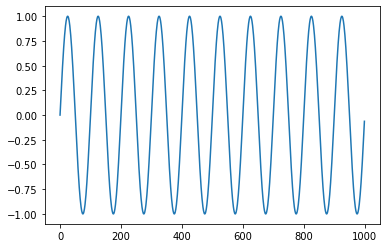

In [111]:
plt.plot(t,S)

### Model noise: Extracting values from a Gaussian distribution
- the Gaussian distribution from which the values are extracted are defined from the [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)
- this fuction has one imput -- the mean (in this case 0, should remain like that for noise)
- additionally you might want to play with the keywords:
> - `scale` = standard devation (noise level)
> - `size` = size of the array (should be the same as the length of the signal `S`

In [99]:
# define noise with a standard deviation of a tenth of the amplitude of the sinusoidal function
noise = np.random.normal(0,scale = A/10, size = N)

In [101]:
# Add the noise to the original function 
Sn = S + noise

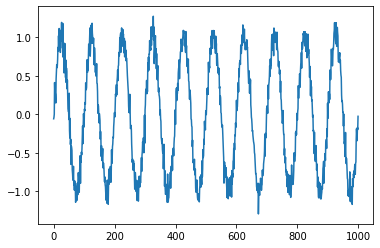

In [102]:
# plot the noise contaminated signal 
plt.plot(t,Sn)

## Your Work:
1) Create your own sine and cosine functions with differen frequencies 
2) Create a function where the frequency of the signal depends on time 
3) Create a function that is a combination of 2 signals with different frequencies 
4) Create a function where you add a sine and a cosine functions with the same frequencies 
5) Plot all of these functions
6) Add noise to these signals (1-4)
7) Plot the noise contaminated functions -- use scale = {A,A/10,A/100} (3 different cases)
6) Try to define the periods of these sign using the `;